In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path


def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()





INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
species = "human"
SRP_name = "aggregates"
resolution = "500kbp_raw"
resolution_human = 500000
#calc_rank_matrix(species, SRP_name, resolution, resolution_human)

In [4]:

    df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_inter.txt', sep='\t')
    contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_{species}/stats/'
    df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'

    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/500kbp_raw/max/spr/hic_gene_corr_inter_excluding_intra_chrom_pairs_hicexp.h5'
    jac_sim_spr = hm.hiCMatrix(exp_file_path)
    all_genes_spr = [x[3].decode() for x in jac_sim_spr.cut_intervals]
    df_jac_corr = pd.DataFrame(jac_sim_spr.matrix.toarray() ,  index=all_genes_spr, columns = all_genes_spr)

    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))
    gene_bed = pd.read_csv(f'{input_path}/all_gene.bed', names=['chr', 'start_bin', 'end_bin', 'gene'])



    if species == 'human':

        all_markers_df = []
        for marker_type in ['class', 'subclass', 'type']:
            marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_type}_markers_top1000.csv.gz', skiprows=1)
            all_markers_df.append(marker_list)

        marker_list = pd.concat(all_markers_df)
        marker_list = marker_list.drop_duplicates(subset=['gene'])
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['Symbol']), right_on='Symbol', left_on='gene') 


        marker_list = marker_list.drop_duplicates(subset=['Ensembl_gene_identifier'])
        all_background_markers = marker_list['Ensembl_gene_identifier'].tolist()
    else:
        marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')

        all_markers_df = []
        for marker_type in ['class', 'subclass', 'cluster']:
            marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_type}_markers.csv')
            all_markers_df.append(marker_list)

        marker_list = pd.concat(all_markers_df)
        marker_list = marker_list.drop_duplicates(subset=['gene'])
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        #df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['gene']), right_on='gene', left_on='gene') 
        #df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        #marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        #marker_list = marker_list.drop_duplicates(subset=['Ensembl_gene_identifier'])
        marker_list = marker_list.drop_duplicates(subset=['gene_id'])
        all_background_markers = marker_list['gene_id'].tolist()




/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [31]:
    with h5py.File(f'{input_path}/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))


    marker_contacts_list_inter = []
    marker_contacts_list_inter_ranked = []

    gene_list = []
    with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                       for key in all_background_markers:
                        if key in tot_g:
                                gene_list.append(key)
                                gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                #which ever chrom the gene falls into, those bins should be nan
                                my_data = hf[key][()]
                                my_data = my_data.astype('float64')
                                my_data[chrom_index_list[gene_chrom]] = np.nan
                                rank_abs  = stats.rankdata(my_data)
                                #predicts2 = rank_abs
                                predicts2 = rank_abs/np.max(rank_abs)
                                predicts2[chrom_index_list[gene_chrom]] = np.nan
                                

                                marker_contacts_list_inter.append(my_data)
                                marker_contacts_list_inter_ranked.append(predicts2)


    my_data = np.array(marker_contacts_list_inter)
    predicts2 = np.array(marker_contacts_list_inter_ranked)

    df_max_gene_inter_by_bins = pd.DataFrame(my_data, index=gene_list, columns = bins_bed['bin_id'].tolist())


    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 1, df_max_gene_inter_by_bins)
    
    predicts2 = predicts2/np.max(predicts2, axis=1, keepdims=True)

    predicts2[np.isnan(my_data)] = np.nan

    outfile_name = f'{input_path}/hic_gene_gw_none_by_allbins_none_ranked_inter.h5'

    with h5py.File(outfile_name, 'a') as hf:

          if 'matrix'in hf:
                del hf['matrix']
                del hf['gene_list']
                del hf['bins_bed']

          hf.create_dataset('matrix',
                      data=predicts2, dtype='float64')
          hf.create_dataset('gene_list',
                      data=gene_list)
          hf.create_dataset('bins_bed',
                      data=bins_bed['bin_id'].tolist(), dtype='int64')

    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

    df_tmp = df_max_gene_inter_by_bins.T.reset_index()


    df_cre_tog = df_cre_1kb_encode.merge(df_tmp, left_on='bin_id', right_on='index', how='right')

    df_cre_tog['cre'] = df_cre_tog['cre'].fillna(0)


    df_cre_tog['true_pos'] =  [1.0 if x>=1 else 0 for x in df_cre_tog['cre']]

    df_cre_tog['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_cre_tog['true_pos']]

    tp_arr = df_cre_tog['true_pos'].values
    tn_arr = df_cre_tog['true_neg'].values

    tp_list = []
    tn_list = []
    for i in gene_list:
        tp_list.append(tp_arr)
        tn_list.append(tn_arr)


    tp  = np.vstack(tp_list)
    tn  = np.vstack(tn_list)

    tp[np.isnan(my_data)] = np.nan
    tn[np.isnan(my_data)] = np.nan

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1)) )- (np.nansum(tp, axis=1) + 1)/2)) / np.nansum(tn, axis=1)
    
    df = pd.DataFrame(columns = ['gene_id_exp_file', 'auc'])  
    df['auc'] = auc_array.tolist()
    df['gene_id_exp_file'] = gene_list

    df.to_csv(f'{input_path}/cre_auc.csv', sep='\t', index=False)







In [33]:
df

gene_id_exp_file       auc
0      ENSG00000128683 -7.492465
1      ENSG00000155974 -7.797567
2      ENSG00000157103 -7.601226
3      ENSG00000136750 -7.821196
4      ENSG00000171189 -8.380818
...                ...       ...
14199  ENSG00000204622 -7.635139
14200  ENSG00000172893 -7.867363
14201  ENSG00000119630 -8.803667
14202  ENSG00000108828 -7.999957
14203  ENSG00000132017 -8.022603

[14204 rows x 2 columns]

In [23]:
rank_abs

array([ 883. , 4228. , 5392. , ..., 5454.5, 5589. , 4867. ])

In [32]:
j = rank_abs/np.max(rank_abs)

TypeError: unsupported operand type(s) for /: 'function' and 'function'

In [30]:
j

array([0.15329861, 0.73402778, 0.93611111, ..., 0.94696181, 0.9703125 ,
       0.84496528])

In [29]:
883/5760

0.15329861111111112

In [20]:
j = rank_abs/np.max(rank_abs)

In [21]:
j.shape

(5760,)

In [17]:
df

gene_id_exp_file       auc
0      ENSG00000128683 -7.492465
1      ENSG00000155974 -7.797567
2      ENSG00000157103 -7.601226
3      ENSG00000136750 -7.821196
4      ENSG00000171189 -8.380818
...                ...       ...
14199  ENSG00000204622 -7.635139
14200  ENSG00000172893 -7.867363
14201  ENSG00000119630 -8.803667
14202  ENSG00000108828 -7.999957
14203  ENSG00000132017 -8.022603

[14204 rows x 2 columns]

In [9]:
    my_data = np.array(marker_contacts_list_inter)
    predicts2 = np.array(marker_contacts_list_inter_ranked)

    df_max_gene_inter_by_bins = pd.DataFrame(predicts2, index=gene_list, columns = bins_bed['bin_id'].tolist())


    #rank_abs = lambda x: stats.rankdata(x)
    #predicts2 = np.apply_along_axis(rank_abs, 1, df_max_gene_inter_by_bins)
    
    #predicts2 = predicts2/np.max(predicts2, axis=1, keepdims=True)

    #predicts2[np.isnan(my_data)] = np.nan

    outfile_name = f'{input_path}/hic_gene_gw_none_by_allbins_none_ranked_inter.h5'

    with h5py.File(outfile_name, 'a') as hf:

          if 'matrix'in hf:
                del hf['matrix']
                del hf['gene_list']
                del hf['bins_bed']

          hf.create_dataset('matrix',
                      data=predicts2, dtype='float64')
          hf.create_dataset('gene_list',
                      data=gene_list)
          hf.create_dataset('bins_bed',
                      data=bins_bed['bin_id'].tolist(), dtype='int64')

    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

    df_tmp = df_max_gene_inter_by_bins.T.reset_index()


    df_cre_tog = df_cre_1kb_encode.merge(df_tmp, left_on='bin_id', right_on='index', how='right')

    df_cre_tog['cre'] = df_cre_tog['cre'].fillna(0)


    df_cre_tog['true_pos'] =  [1.0 if x>=1 else 0 for x in df_cre_tog['cre']]

    df_cre_tog['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_cre_tog['true_pos']]

    tp_arr = df_cre_tog['true_pos'].values
    tn_arr = df_cre_tog['true_neg'].values

    tp_list = []
    tn_list = []
    for i in gene_list:
        tp_list.append(tp_arr)
        tn_list.append(tn_arr)


    tp  = np.vstack(tp_list)
    tn  = np.vstack(tn_list)

    tp[np.isnan(my_data)] = np.nan
    tn[np.isnan(my_data)] = np.nan

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1)) )- (np.nansum(tp, axis=1) + 1)/2)) / np.nansum(tn, axis=1)
    
    df = pd.DataFrame(columns = ['gene_id_exp_file', 'auc'])  
    df['auc'] = auc_array.tolist()
    df['gene_id_exp_file'] = gene_list
    
    

In [144]:
                df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-dels.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

                df_cre['start_bin'] = df_cre['start']/resolution_human
                df_cre['start_bin'] = df_cre['start_bin'].astype('int')
                df_cre['start_bin'] = df_cre['start_bin']*resolution_human
                df_cre['start_bin'] = df_cre['start_bin'].astype('str')
                df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
                #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
                df_cre['cre'] = 1
                df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
                df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

In [151]:
    df_tmp = df_max_gene_inter_by_bins.T.reset_index()


    df_cre_tog = df_cre_1kb_encode.merge(df_tmp, left_on='bin_id', right_on='index', how='right')

    df_cre_tog['cre'] = df_cre_tog['cre'].fillna(0)


    df_cre_tog['true_pos'] =  [1.0 if x>=6 else 0 for x in df_cre_tog['cre']]

    df_cre_tog['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_cre_tog['true_pos']]

    tp_arr = df_cre_tog['true_pos'].values
    tn_arr = df_cre_tog['true_neg'].values

    tp_list = []
    tn_list = []
    for i in gene_list:
        tp_list.append(tp_arr)
        tn_list.append(tn_arr)


    tp  = np.vstack(tp_list)
    tn  = np.vstack(tn_list)

    tp[np.isnan(my_data)] = np.nan
    tn[np.isnan(my_data)] = np.nan

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1)) )- (np.nansum(tp, axis=1) + 1)/2)) / np.nansum(tn, axis=1)
    
    df = pd.DataFrame(columns = ['gene_id_exp_file', 'auc'])  
    df['auc'] = auc_array.tolist()
    df['gene_id_exp_file'] = gene_list

In [153]:
df['auc'].mean()

0.64150074615051

In [10]:
auc_array

array([-7.49246534, -7.79756665, -7.60122611, ..., -8.80366736,
       -7.99995746, -8.02260302])

In [6]:
predicts2

array([[0.06996528, 0.11519097, 0.41640625, ..., 0.31527778, 0.409375  ,
        0.09522569],
       [0.06944444, 0.1       , 0.16883681, ..., 0.32873264, 0.39487847,
        0.09348958],
       [0.071875  , 0.21701389, 0.54652778, ..., 0.58645833, 0.62482639,
        0.10755208],
       ...,
       [0.06736111, 0.51788194, 0.81059028, ..., 0.78229167, 0.86076389,
        0.51666667],
       [0.07673611, 0.75902778, 0.9265625 , ..., 0.90138889, 0.94027778,
        0.78072917],
       [0.15329861, 0.73402778, 0.93611111, ..., 0.94696181, 0.9703125 ,
        0.84496528]])

In [25]:
pd.read_csv(f'{input_path}/cre_auc.csv', sep='\t')

gene_id_jac_sim       auc gene_id_exp_file
0                  NaN  0.996604  ENSG00000128683
1                  NaN  0.996445  ENSG00000155974
2                  NaN  0.996517  ENSG00000157103
3                  NaN  0.994976  ENSG00000136750
4                  NaN  0.991019  ENSG00000171189
...                ...       ...              ...
14199              NaN  0.988937  ENSG00000204622
14200              NaN  0.996578  ENSG00000172893
14201              NaN  0.996811  ENSG00000119630
14202              NaN  0.997310  ENSG00000108828
14203              NaN  0.996962  ENSG00000132017

[14204 rows x 3 columns]

In [5]:
pd.read_csv(f'{input_path}/cre_auc.csv', sep='\t')

gene_id_exp_file       auc
0      ENSG00000128683 -7.492465
1      ENSG00000155974 -7.797567
2      ENSG00000157103 -7.601226
3      ENSG00000136750 -7.821196
4      ENSG00000171189 -8.380818
...                ...       ...
14199  ENSG00000204622 -7.635139
14200  ENSG00000172893 -7.867363
14201  ENSG00000119630 -8.803667
14202  ENSG00000108828 -7.999957
14203  ENSG00000132017 -8.022603

[14204 rows x 2 columns]

In [2]:
species = "human"
SRP_name = "aggregates"
resolution = "10kbp_raw"
resolution_human = 10000

In [35]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_ranked_inter.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]
    

In [166]:
my_data_norm = my_data/np.nanmax(my_data, axis=1, keepdims=True)

In [167]:
my_data_norm

array([[0.05121748, 0.14986764, 0.05121748, ..., 0.05121748, 0.14986764,
        0.05121748],
       [0.03634825, 0.0995875 , 0.08326981, ..., 0.11989343, 0.0995875 ,
        0.03634825],
       [0.05150012, 0.15394185, 0.05150012, ..., 0.52621237, 0.15394185,
        0.05150012],
       ...,
       [0.09703978, 0.31563128, 0.09703978, ..., 0.71679239, 0.71679239,
        0.09703978],
       [0.07249904, 0.23223298, 0.07249904, ..., 0.72733297, 0.59641346,
        0.07249904],
       [0.08825942, 0.6787468 , 0.08825942, ..., 0.7933548 , 0.28812308,
        0.08825942]])

In [168]:
my_data_norm.shape

(14204, 287509)

In [171]:
tp.shape

(14204, 287509)

In [176]:
np.where(tp[0, :] == 1)

(array([    83,     84,     93, ..., 287496, 287499, 287500]),)

In [177]:
my_data_tp = my_data_norm.T[np.where(tp[0, :] == 1)[0]].T

In [186]:
my_data_tp.max()

nan

In [187]:
fig_h = sns.heatmap(my_data_tp)
fig = fig_h.get_figure()
fig.savefig(f"/grid/gillis/home/lohia/notebooks_proj2_marker/out.pdf") 

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff2e1f92550> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff2e1b2cdc0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
sns.clustermap(
    my_data_tp,
    figsize=(7, 5),
    row_cluster=False,
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [170]:
tp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
df_max_gene_inter_by_bins = pd.DataFrame(my_data, index=gene_list, columns = bins_bed)

In [134]:
my_percen = np.nanpercentile(my_data, 70, axis=1, keepdims=True)

In [9]:
my_data

array([[ 13485. ,  39458.5,  13485. , ...,  13485. ,  39458.5,  13485. ],
       [  9966. ,  27305. ,  22831. , ...,  32872.5,  27305. ,   9966. ],
       [ 13785.5,  41207. ,  13785.5, ..., 140856. ,  41207. ,  13785.5],
       ...,
       [ 26861. ,  87368. ,  26861. , ..., 198411. , 198411. ,  26861. ],
       [ 20240.5,  64835.5,  20240.5, ..., 203059. , 166508.5,  20240.5],
       [ 24858. , 191167. ,  24858. , ..., 223446. ,  81149. ,  24858. ]])

In [21]:
my_percen

array([[260629. ],
       [270990.5],
       [265528.5],
       ...,
       [274208.5],
       [276752. ],
       [278966. ]])

In [17]:
thresh = np.array([[13485, 7, 9, 11, 13, 15]])

In [18]:
thresh

array([[13485,     7,     9,    11,    13,    15]])

In [19]:
my_data > thresh

ValueError: operands could not be broadcast together with shapes (14204,287509) (1,6) 

In [43]:
np.where(tp[0, :] == 1)[0]

array([    83,     84,     90, ..., 287497, 287499, 287500])

In [135]:
my_data_thresh = my_data > my_percen

my_data_thresh = my_data_thresh.astype(int)

In [137]:
my_data_thresh_sum = my_data_thresh.sum(axis=0)

In [53]:
my_data_thresh.shape

(14204, 287509)

In [56]:
my_data_thresh_sum.max()

13299

In [138]:
tp_sum_val = my_data_thresh_sum[np.where(tp[0, :] == 1)[0]]

In [130]:
%matplotlib inline
import seaborn as sns

<AxesSubplot:ylabel='Count'>

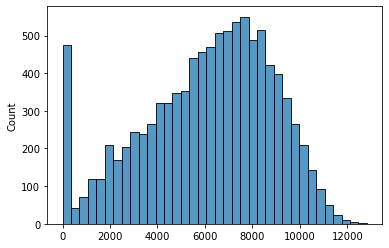

In [139]:
sns.histplot(tp_sum_val)

<AxesSubplot:ylabel='Count'>

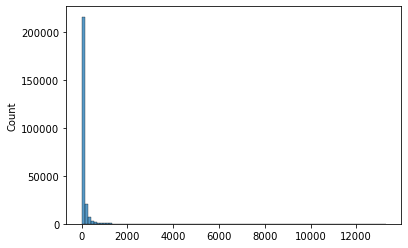

In [133]:
sns.histplot(tp_sum_val,bins=100)

In [70]:
%matplotlib inline
import seaborn as sns

df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_inter.txt', sep='\t')
contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_{species}/stats/'
df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])



empty_list_2 = []
empty_list_1 = []
for SRP_name in df_con['id'].tolist():
    
    try:

        input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'

        df = pd.read_csv(f'{input_path}/cre_auc_6.csv', sep='\t')
        empty_list_1.append(df['auc'].mean())
        df_seq_depth_subset = df_seq_depth[df_seq_depth['proj_id'].isin([SRP_name])]
        empty_list_2.append(df_seq_depth_subset['counts_inter'].sum())
    except:
        pass


for SRP_name in ['aggregates']:
    
    try:

        input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'

        df = pd.read_csv(f'{input_path}/cre_auc_6.csv', sep='\t')
        empty_list_1.append(df['auc'].mean())
        df_seq_depth_subset = df_seq_depth
        empty_list_2.append(df_seq_depth['counts_inter'].sum())
    except:
        pass

<AxesSubplot:xlabel='auc', ylabel='Count'>

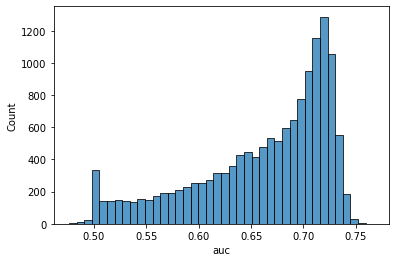

In [118]:
sns.histplot(df['auc'])

In [143]:
len(empty_list_2)

120

In [95]:
empty_list_2

[285392948,
 8197215080,
 4477597526,
 8302243136,
 2185645872,
 6886082828,
 132903680,
 1129505102,
 123119904,
 2305027284,
 546862796,
 1998484964,
 2608729346,
 2782546408,
 309655002,
 1267714410,
 502487970,
 266536114,
 3777635932,
 591042632,
 3282665126,
 4717992990,
 447962218,
 1257810114,
 2437086938,
 508607976,
 1082973944,
 1061912766,
 1077624722,
 397855762,
 243666942,
 1664460512,
 182950354,
 444076294,
 1138792074,
 840189852,
 711990832,
 790857054,
 1589460650,
 195686728,
 1260196942,
 630237068,
 439616526,
 738008408,
 62302550,
 585379552,
 10734504,
 282477152,
 512694922,
 746428438,
 1470421972,
 443711148,
 47718444,
 1293463292,
 308762292,
 147184660,
 3558738228,
 452587054,
 655156728,
 1242835014,
 57894106,
 690667732,
 97993686,
 340956750,
 79678952,
 237077390,
 462355800,
 158537228,
 66026420,
 91672496,
 478796854,
 106747742,
 411186374,
 140773854,
 34423652,
 7568,
 132526026,
 48112318,
 167019524,
 305495902,
 134998720,
 106142904,
 111

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

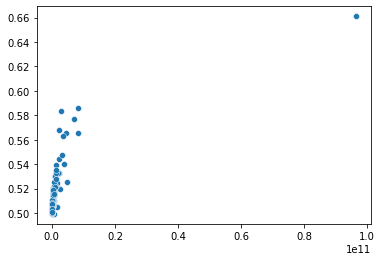

In [142]:
sns.scatterplot(empty_list_2, empty_list_1)

In [58]:
my_data_thresh_sum[np.where(tp[0, :] == 0)[0]]

array([  0, 104,   5, ..., 217,  48,   0])

In [47]:
my_data_thresh_sum

NameError: name 'my_data_thresh_sum' is not defined

In [29]:
predicts2 = my_data

In [124]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

    df_tmp = df_max_gene_inter_by_bins.T.reset_index()


    df_cre_tog = df_cre_1kb_encode.merge(df_tmp, left_on='bin_id', right_on='index', how='right')

    df_cre_tog['cre'] = df_cre_tog['cre'].fillna(0)


    df_cre_tog['true_pos'] =  [1.0 if x>=14 else 0 for x in df_cre_tog['cre']]

    df_cre_tog['true_neg'] = [0 if x == 1.0 else 1.0 for x in df_cre_tog['true_pos']]

    tp_arr = df_cre_tog['true_pos'].values
    tn_arr = df_cre_tog['true_neg'].values

    tp_list = []
    tn_list = []
    for i in gene_list:
        tp_list.append(tp_arr)
        tn_list.append(tn_arr)


    tp  = np.vstack(tp_list)
    tn  = np.vstack(tn_list)

    tp[np.isnan(my_data)] = np.nan
    tn[np.isnan(my_data)] = np.nan

    pos_rank_sum = tp * predicts2
    auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1)) )- (np.nansum(tp, axis=1) + 1)/2)) / np.nansum(tn, axis=1)
    
    df = pd.DataFrame(columns = ['gene_id_exp_file', 'auc'])  
    df['auc'] = auc_array.tolist()
    df['gene_id_exp_file'] = gene_list
    

In [128]:
df['auc'].mean()

0.6666435884695303

In [119]:
df_cre_tog['true_pos'].sum()/287509

0.23691432268207255

In [134]:
tp_arr

array([0., 0., 0., ..., 0., 0., 0.])

In [119]:
df_cre_1kb_encode

start_bin  cre    chr      start        end  bin_id  \
0           chr10_10000    1  chr10      10000      20000  167493   
1          chr10_100000    1  chr10     100000     110000  167502   
2         chr10_1000000    1  chr10    1000000    1010000  167592   
3        chr10_10000000    6  chr10   10000000   10010000  168492   
4       chr10_100000000   16  chr10  100000000  100010000  177492   
...                 ...  ...    ...        ...        ...     ...   
213396    chr9_99940000    1   chr9   99940000   99950000  163646   
213397    chr9_99950000    1   chr9   99950000   99960000  163647   
213398    chr9_99960000    1   chr9   99960000   99970000  163648   
213399    chr9_99970000    2   chr9   99970000   99980000  163649   
213400    chr9_99990000    1   chr9   99990000  100000000  163651   

                    pos  
0           chr10_10000  
1          chr10_100000  
2         chr10_1000000  
3        chr10_10000000  
4       chr10_100000000  
...                 ...  
213396    chr9_99940000  
213397    chr9_99950000  
213398    chr9_99960000  
213399    chr9_99970000  
213400    chr9_99990000  

[213401 rows x 7 columns]

In [38]:
df['auc'].mean()

0.6610481099362371

In [133]:
df['auc'].mean()

0.6610481099362371

In [91]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

In [86]:
 df_cre_1kb_encode

start_bin  cre    chr      start        end  bin_id  \
0           chr10_10000    1  chr10      10000      20000  167493   
1          chr10_100000    1  chr10     100000     110000  167502   
2         chr10_1000000    1  chr10    1000000    1010000  167592   
3        chr10_10000000    6  chr10   10000000   10010000  168492   
4       chr10_100000000   16  chr10  100000000  100010000  177492   
...                 ...  ...    ...        ...        ...     ...   
213396    chr9_99940000    1   chr9   99940000   99950000  163646   
213397    chr9_99950000    1   chr9   99950000   99960000  163647   
213398    chr9_99960000    1   chr9   99960000   99970000  163648   
213399    chr9_99970000    2   chr9   99970000   99980000  163649   
213400    chr9_99990000    1   chr9   99990000  100000000  163651   

                    pos  
0           chr10_10000  
1          chr10_100000  
2         chr10_1000000  
3        chr10_10000000  
4       chr10_100000000  
...                 ...  
213396    chr9_99940000  
213397    chr9_99950000  
213398    chr9_99960000  
213399    chr9_99970000  
213400    chr9_99990000  

[213401 rows x 7 columns]

In [150]:
df_cre_1kb_encode[df_cre_1kb_encode['cre']>=6].shape[0] / (2875012/10)

0.164061923915448

In [160]:
species = "human"
SRP_name = "aggregates"
resolution = "10kbp_raw"
resolution_human = 10000

In [161]:
input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
outfile_name = f'{input_path}/hic_gene_gw_none_by_allbins_none_ranked_inter.h5'

In [162]:
df = pd.read_csv(f'{input_path}/cre_auc_1.csv', sep='\t')

In [163]:
df['auc'].mean()

0.7093518882882045

In [98]:
df['auc'].mean()

0.6346230370225541

In [99]:
%matplotlib inline
import seaborn as sns

<AxesSubplot:xlabel='auc', ylabel='Count'>

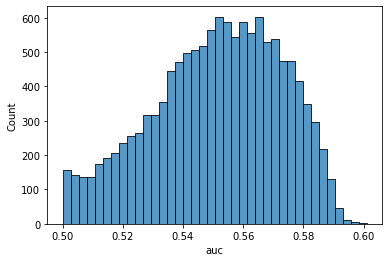

In [108]:
sns.histplot(df['auc'])

In [55]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_ranked_inter.h5', 'r') as hf:
    data = hf['matrix'][:]
    

In [52]:
np.percentile(data, 99, axis=1, keepdims=True)

1.0

In [56]:
data.shape

(12855, 2875012)

In [37]:
data[data > 0.1] = 

array([[0.06996528, 0.11519097, 0.41640625, ..., 0.31527778, 0.409375  ,
        0.09522569],
       [0.06944444, 0.1       , 0.16883681, ..., 0.32873264, 0.39487847,
        0.09348958],
       [0.071875  , 0.21701389, 0.54652778, ..., 0.58645833, 0.62482639,
        0.10755208],
       ...,
       [0.06736111, 0.51788194, 0.81059028, ..., 0.78229167, 0.86076389,
        0.51666667],
       [0.07673611, 0.75902778, 0.9265625 , ..., 0.90138889, 0.94027778,
        0.78072917],
       [0.15329861, 0.73402778, 0.93611111, ..., 0.94696181, 0.9703125 ,
        0.84496528]])

In [42]:
data[data > 0.1] = 1

In [44]:
data[data != 1] = 0

In [45]:
data

array([[0., 1., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [41]:
np.percentile(a, 99)

3.9699999999999998

In [40]:
a = np.array([[1, 2], [3, 4]])

In [31]:
a

array([[1, 2],
       [3, 4]])

In [42]:
np.max(a, axis=1, keepdims=True)

array([[nan],
       [ 4.]])

In [43]:
a/np.max(a, axis=1, keepdims=True)

array([[ nan,  nan],
       [0.75, 1.  ]])